In [1]:
#dependency according to https://github.com/salesforce/CodeT5#dependency
!pip install transformers==4.6.1

     |████████████████████████████████| 2.2 MB 15.7 MB/s 
     |████████████████████████████████| 880 kB 10.5 MB/s 
     |████████████████████████████████| 3.3 MB 43.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=e67f178f744595f1bf95066b19ab944fc3ffc1664ae6e75cc4a1ba0cf31bcfd8
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [2]:
#imports
from transformers import RobertaTokenizer, T5ForConditionalGeneration
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')
data_path = '/content/gdrive/My Drive/Final project_DeepLearning'

Mounted at /content/gdrive/


In [5]:
import os
os.chdir(data_path+'/java-corpus/token_completion')

In [ ]:
#preprocess the data
!python preprocess_java.py --base_dir=token_completion --output_dir=token_completion

In [ ]:
!ls

dev.txt  test.json  train.txt


In [6]:
class Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.code_
        self.ctext = self.data.code_

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        ctext = str(self.ctext[index])
        ctext = ' '.join(ctext.split())

        text = str(self.text[index])
        text = ' '.join(text.split())

        # source = self.tokenizer.batch_encode_plus([self.text], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        # target = self.tokenizer.batch_encode_plus([self.otext], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')
        # print([self.text][0])
        source = self.tokenizer([text], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer([ctext], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

In [7]:
def train(epoch, tokenizer, model, device, loader, optimizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_loss = []
    torch.save(model,'my_checkpoint.pth.tar')
    torch.save(model, data_path+'my_checkpoint.pth.tar')
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        loss = outputs[0]
        train_loss.append(loss.item())
        if _%100==0:
          print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("=> Saving checkpoint")        
    return train_loss

In [24]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    final_df = pd.DataFrame(columns = ["Generated Text","Actual Text"])
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=550, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
            values = [list(i) for i in zip(preds,target)]

            #create a temporary dataframe for the predicted texts of the current iteration
            df = pd.DataFrame(values, columns=["Generated Text","Actual Text"])

            #Concat to the original dataframe
            final_df = pd.concat([final_df, df], ignore_index=True)
            # final_df['Generated Text'] = predictions
            # final_df['Actual Text'] = actuals
            final_df.to_csv('predictions_token.csv')
    return predictions, actuals

In [12]:
Train_batch  = 8
Valid_batch = 8
epochs = 1
val_epochs = 1
learning_rate = 1e-4
seed = 42
max_len = 512
output_len = 150

In [ ]:
# Set random seeds and deterministic pytorch for reproducibility
torch.manual_seed(seed) # pytorch random seed
np.random.seed(seed) # numpy random seed
torch.backends.cudnn.deterministic = True

# tokenzier for encoding the text
tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-small')

train_data = pd.read_csv('train.txt', sep='<s>', header = None)
dev_data = pd.read_csv('dev.txt', sep='<s>', header = None)

#apply <s> at the beginning
train_data.columns = ['idx', 'code']
train_data['code_'] = train_data['code'].apply(lambda x:'<s> '+x)

dev_data.columns = ['idx', 'code']
dev_data['code_'] = dev_data['code'].apply(lambda x:'<s> '+x)

print("TRAIN Dataset: {}".format(train_data.shape))
print("VAL Dataset: {}".format(dev_data.shape))

#calling the dataset class 
training_set = Dataset(train_data, tokenizer, max_len, output_len)
val_set = Dataset(dev_data, tokenizer, max_len, output_len)

# Defining the parameters for creation of dataloaders
train_params = {
    'batch_size': Train_batch,
    'shuffle': True,
    'num_workers': 2
    }

val_params = {
    'batch_size': Valid_batch,
    'shuffle': False,
    'num_workers': 2
    }

# Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
training_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(val_set, **val_params)

model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-small')

model = model.to(device)

# Defining the optimizer that will be used to tune the weights of the network in the training session. 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


TRAIN Dataset: (12928, 3)
VAL Dataset: (7151, 3)


In [ ]:
# Training loop
for epoch in range(epochs):
    training_loss = train(epoch, tokenizer, model, device, training_loader, optimizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Epoch: 0, Loss:  11.65631103515625
Epoch: 0, Loss:  0.1891576647758484
Epoch: 0, Loss:  0.10172505676746368
Epoch: 0, Loss:  0.08996093273162842
Epoch: 0, Loss:  0.053098827600479126
Epoch: 0, Loss:  0.0554431714117527
Epoch: 0, Loss:  0.0714089646935463
Epoch: 0, Loss:  0.05402199178934097
Epoch: 0, Loss:  0.04175151139497757
Epoch: 0, Loss:  0.043756019324064255
Epoch: 0, Loss:  0.05515299364924431
Epoch: 0, Loss:  0.03199891000986099
Epoch: 0, Loss:  0.04672214388847351
Epoch: 0, Loss:  0.03528938814997673
Epoch: 0, Loss:  0.03430168703198433
Epoch: 0, Loss:  0.044024012982845306
Epoch: 0, Loss:  0.05026824027299881
=> Saving checkpoint


Text(0, 0.5, 'Training loss ')

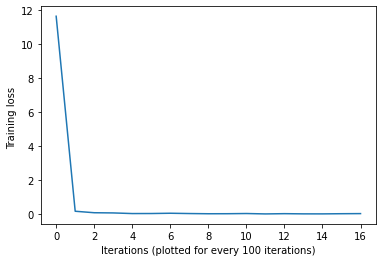

In [6]:
plt.plot(training_loss)
plt.xlabel('Iterations (plotted for every 100 iterations)')
plt.ylabel('Training loss ')

In [ ]:
test = pd.read_json('test.json', lines=True)

In [ ]:
test

,id,input,gt
0,51,<s> import threading <EOL> import IECore <EOL>...,
1,40753,"<s> import re , operator <EOL> def str_find_al...",
2,32889,<s> import unittest <EOL> import pymel . inter...,
3,49349,<s> import time <EOL> import logging <EOL> imp...,
4,27038,<s> import os <EOL> import os . path as osp <E...,
...,...,...,...
9995,13140,"<s> """"""<STR_LIT>"""""" <EOL> try : <EOL> from cPi...",
9996,9254,<s> from pypy . rpython . lltypesystem import ...,
9997,24242,<s> import itertools <EOL> import time <EOL> c...,
9998,44099,"<s> """"""<STR_LIT>"""""" <EOL> import os <EOL> impo...",


In [ ]:
test.columns
test.rename(columns={'input': 'code_'}, inplace=True)

In [ ]:
test['gt']

0        
1        
2        
3        
4        
       ..
9995     
9996     
9997     
9998     
9999     
Name: gt, Length: 10000, dtype: object

In [ ]:
#-------------------------------------------------------------------
# Testing and saving the results to a dataframe - line completion task
#-------------------------------------------------------------------

vt_set = Dataset(test, tokenizer, max_len, output_len)
test_params = {
    'batch_size': 8,
    'shuffle': False,
    'num_workers': 2
    }
test_loader = DataLoader(vt_set, **val_params)
for epoch in range(val_epochs):
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Completed 0
Completed 100
Completed 200
Completed 300


In [ ]:
#---------------------------------------------------------------
#result metrics
#---------------------------------------------------------------
from nltk.metrics import edit_distance    
final_df["distance"] = final_df.loc[:, ["Generated Text","Actual Text"]].apply(lambda x: edit_distance(*x), axis=1)

In [ ]:
final_df["exact_match"] = final_df.loc[:, ["Generated Text","Actual Text"]].apply(lambda x: 1 (if x["Generated Text"].split()==x["Actual Text"].split()) else 0)

In [ ]:
print("Edit distance: ", final_df["distance"].mean())

Edit distance:  113.64019018319117


In [ ]:
final_df

In [ ]:
final_df.to_csv('predictions.csv')

In [14]:
model = torch.load(data_path+'my_checkpoint.pth.tar', map_location=torch.device('cpu'))

In [ ]:
#Example inference
tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-small')

text = "def (user): print(f'hello!')"
input_ids = tokenizer(text, return_tensors="pt").input_ids

# simply generate one code span
generated_ids = model.generate(input_ids, max_length = 50)   #line_generation
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))

user.send(user.name) print(f'hello!')


# Token level inferencing

In [ ]:
#getting the test file for token completion task

!wget -O test.txt https://zenodo.org/record/3628665/files/java_test_pre

--2022-05-09 13:51:11--  https://zenodo.org/record/3628665/files/java_test_pre
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26969670 (26M) [application/octet-stream]
Saving to: ‘test.txt’

test.txt            100%[===================>]  25.72M  1.28MB/s    in 41s     

2022-05-09 13:51:54 (640 KB/s) - ‘test.txt’ saved [26969670/26969670]



In [9]:
#--------------------------------------------------------------------------------
#token level inferencing
#--------------------------------------------------------------------------------
test_token = pd.read_csv("test.txt", sep='<s>', header = None)
test_token.columns = ['idx', 'code']
test_token['code_'] = test_token['code'].apply(lambda x:'<s> '+x)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
test_token

,idx,code,code_
0,NaN,package org . vaadin . teemu . clara . demo ;...,<s> package org . vaadin . teemu . clara . de...
1,NaN,package org . vaadin . teemu . clara . demo ;...,<s> package org . vaadin . teemu . clara . de...
2,NaN,package org . vaadin . teemu . clara ; import...,<s> package org . vaadin . teemu . clara ; im...
3,NaN,package org . vaadin . teemu . clara . util ;...,<s> package org . vaadin . teemu . clara . ut...
4,NaN,package org . vaadin . teemu . clara ; import...,<s> package org . vaadin . teemu . clara ; im...
...,...,...,...
8263,NaN,package journal . io . util ; import java . u...,<s> package journal . io . util ; import java...
8264,NaN,package journal . io . util ; import java . i...,<s> package journal . io . util ; import java...
8265,NaN,package journal . io . api ; import java . io...,<s> package journal . io . api ; import java ...
8266,NaN,package journal . io . api ; import java . io...,<s> package journal . io . api ; import java ...


In [25]:
tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-small')

test_token_set = Dataset(test_token, tokenizer, max_len, output_len)
test_params = {
    'batch_size': 8,
    'shuffle': False,
    'num_workers': 2
    }
test_loader = DataLoader(test_token_set, **test_params)
for epoch in range(val_epochs):
    predictions, actuals = validate(epoch, tokenizer, model, device, test_loader)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Completed 0
Completed 100
Completed 200
Completed 300
Completed 400
Completed 500
Completed 600
Completed 700
Completed 800
Completed 900
Completed 1000


In [36]:
tmp = pd.read_csv("predictions_token.csv", index_col=0)

In [37]:
tmp.columns

Index(['Generated Text', 'Actual Text'], dtype='object')

In [38]:
predictions = list(tmp['Generated Text'])
actuals = list(tmp['Actual Text'])

In [42]:
#-------------------------------------------------------------
#accuracy of predictions..
#Based on the evaluator.py script from CodeXGLUE
#--------------------------------------------------------------

total = 0
correct = 0.0
for pred, gt in zip(predictions, actuals):
    pred = pred.split()
    gt = gt.split()
    for x, y in zip(pred, gt):
        if y not in ["<s>", "</s>", "<EOL>", "<pad>"]:
            total += 1
            if x == y:
                correct += 1
print((f"Total {total} tokens, accuracy: {round(correct/total*100, 2)}"))

Total 204001 tokens, accuracy: 0.83


In [45]:
text = "<s> import json <EOL> json . load ( f ) </s>"
input_ids = tokenizer(text, return_tensors="pt").input_ids

# simply generate one code span
generated_ids = model.generate(input_ids, max_length = 10)   #token completion example
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))

def parse_json ( f )


In [ ]:
#------------------------------------------------------
#understanding the data (should've been done at the beginning)
#------------------------------------------------------

data = pd.read_csv("train.csv", sep='<s>', header = None)

In [ ]:
data['CodeLength'] = data['code'].apply(lambda x:len(x.split()))

In [ ]:
#check the highest, lowest and the mean of the lengths of the code
print("Maximum code length ", max(data['CodeLength']))
print("Minimum code length ", min(data['CodeLength']))
print("mean code length ", data['CodeLength'].mean())

Maximum code length  264199
Minimum code length  6
mean code length  1212.4225711633662


In [ ]:
'''
references:
https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb
https://towardsdatascience.com/guide-to-fine-tuning-text-generation-models-gpt-2-gpt-neo-and-t5-dc5de6b3bc5e
https://shivanandroy.com/fine-tune-t5-transformer-with-pytorch/
https://codeutility.org/huggingface-t5-transformer-model-how-to-prep-a-custom-dataset-for-fine-tuning/
'''